## Модель распространения частичной разметки фаций в 3D сейсмике

## Содержание
* [Постановка задачи](#Постановка задачи)
* [Зависимости](#Зависимости)
* [Датасет](#Датасет)
* [Архитектура модели](#Архитектура-модели)
* [Обучение модели](#Обучение-модели)
* [Сходимость процесса обучения](#Сходимость-процесса-обучения)
* [Оценка модели](#Оценка-модели)
* [Критика модели](#Критика-модели)
* [Краткое резюме](#Краткое-резюме)
* [Предложения по улучшению и развитию модели](#Предложения-по-улучшению-и-развитию-модели)

## Постановка задачи
Распространить частичную разметку фаций, выполенную на одном среде 3D куба сейсмики, на весь куб сейсмики.

## Зависимости
Решение использует следующий набор библиотек

In [22]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

import tensorflow as tf

from dataset import Dataset, FilesIndex, B, V, F
from dataset.models.tf import TFModel

import dataset as ds
from seismic_batch import SeismicBatch
from utils import IndexTracker, update_counters, get_slice_index, get_start_index

from dataset.models.tf import VGG7, ResNet18, TFModel

## Датасет

Используется датасет Dutch F3 из открытого источника [https://drive.google.com/drive/folders/0B7brcf-eGK8CRUhfRW9rSG91bW8](https://drive.google.com/drive/folders/0B7brcf-eGK8CRUhfRW9rSG91bW8). Датасет состоит из файла с 3D кубом сейсмических данных и набора файлов с разметкой на каждый тип фаций.

Основные параметры куба сейсмики:
* размер (651, 951, 462) по осям (i-line, x-line, samples)
* формат `segy`

Основные параметры разметки:
* 1 частично размеченый срез (x-line, depth)
* 9 выделенных фаций
* формат `pts` (координаты точек куба, относящиеся к данному типу фаций)
* от 7К до 20К точек на разные типы фаций.

Процедура определения датасета:

In [2]:
dindex = FilesIndex(path="/home/egor/Desktop/Dutch F3 seismic data/D*.segy")
imset = Dataset(dindex, SeismicBatch)

Загрузка куба сейсмики

In [3]:
batch = imset.next_batch(1).load(fmt="segy")

Размеры куба

In [4]:
batch.traces[0].shape

(651, 951, 462)

Просмотр куба вдоль любой размерности (параметр `axis`). Скролл по картинке переключает срезы вдоль выбранной размерности с шагом `scroll_step`.

<IPython.core.display.Javascript object>


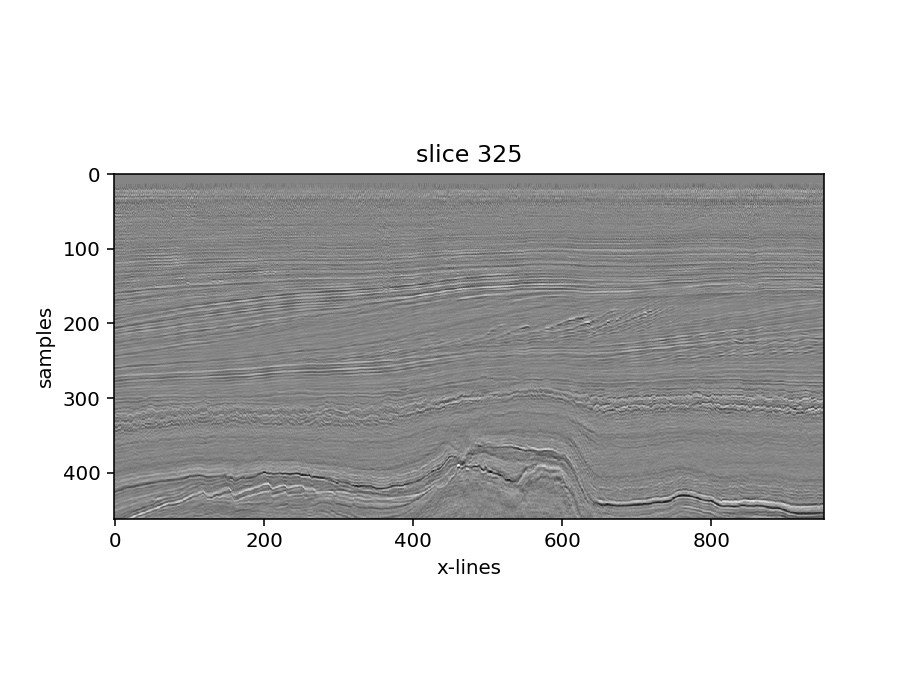

In [23]:
%matplotlib notebook

axis = 0
scroll_step = 10

traces = batch.traces[0]
order = np.hstack((np.delete(np.arange(traces.ndim), axis)[::-1], axis))
axes_names = np.delete(["i-lines", "x-lines", "samples"], axis)

fig, ax = plt.subplots(1, 1)
ax.set_xlabel(axes_names[0]), ax.set_ylabel(axes_names[1])
tracker = IndexTracker(ax, np.transpose(traces, order), scroll_step)
fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

Загрузка разметки

In [6]:
batch = batch.load(fmt="pts")

Просмотр размеченных фаций

<IPython.core.display.Javascript object>


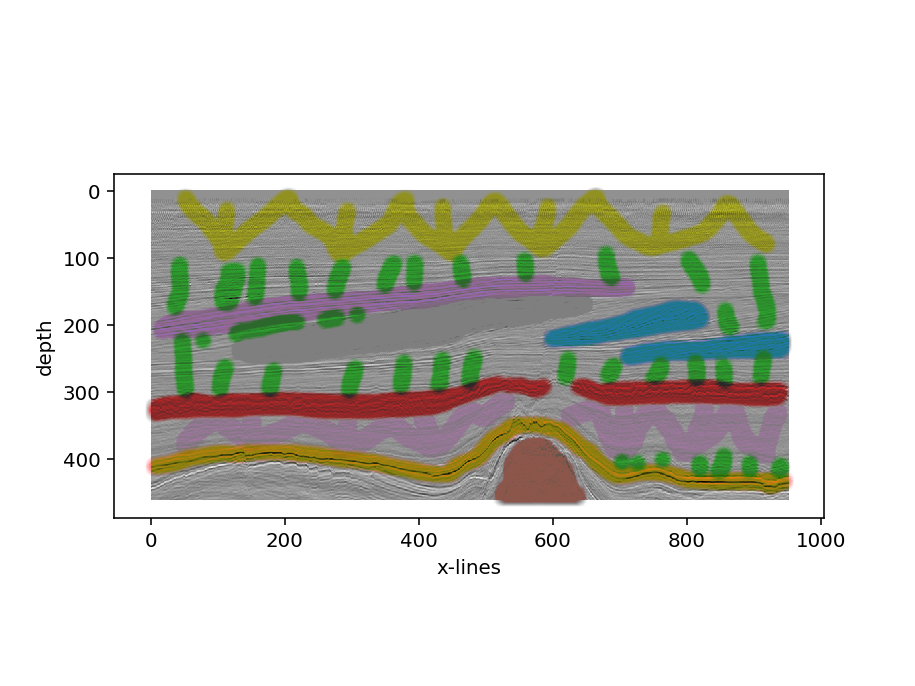

In [24]:
%matplotlib notebook

slice_axis = 0

start = batch.meta[0].ilines[0]
step = batch.meta[0].ilines[1] - batch.meta[0].ilines[0]
annotated_slice = int((batch.annotation[0][0][0, 0] - start) / step)

batch.show_slice(batch.indices[0], slice_axis, annotated_slice, show_pts=True)

Создание одного сэмла кропов, по которым будет происходить обучение. Кроп имеен размеры 24х24 по пространственной размерности и 8 по глубине. Первые шесть каналов представляют сдвиги одномерного кропа вправо-влево и вверх-вниз на размер кропа. Два последних канала содержат координаты пикселей кропа.

In [8]:
crop_half_size = 12
imbatch = batch.sample_crops(slice_axis, annotated_slice, crop_half_size, 1)

Первые три канала (одномерный кроп + сдвиги вправо и влево)

<IPython.core.display.Javascript object>


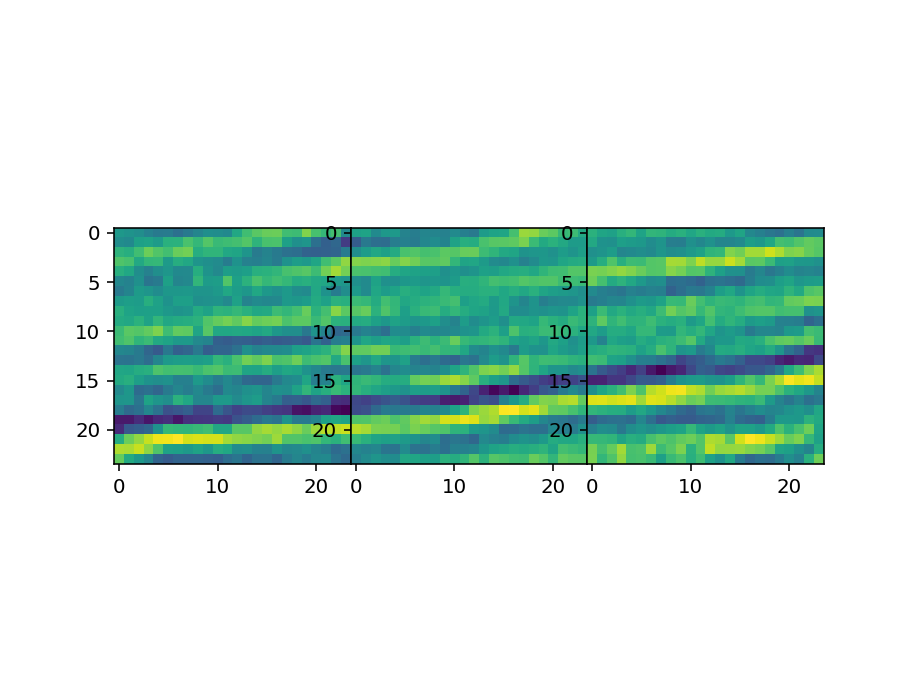

In [25]:
%matplotlib notebook
crop = imbatch.images[0]
fig, ax = plt.subplots(1, 3)
ax[0].imshow(crop[:, :, 0].T)
ax[1].imshow(crop[:, :, 1].T)
ax[2].imshow(crop[:, :, 2].T)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

Следующие три канала (одномерный кроп + сдвиги вверх и вниз)

<IPython.core.display.Javascript object>


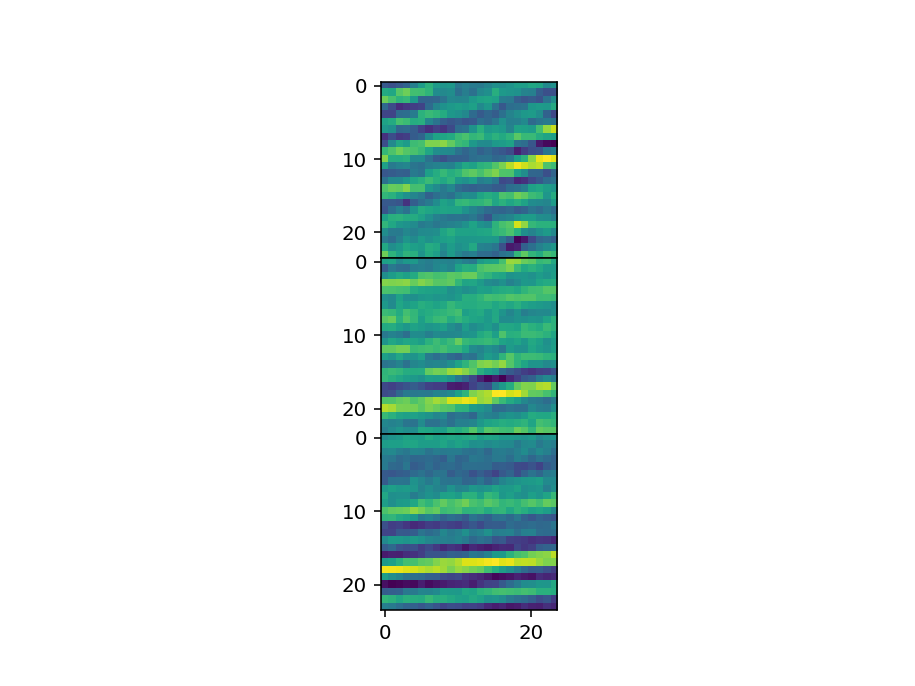

In [26]:
%matplotlib notebook
crop = imbatch.images[0]
fig, ax = plt.subplots(3, 1)
ax[0].imshow(crop[:, :, 3].T)
ax[1].imshow(crop[:, :, 4].T)
ax[2].imshow(crop[:, :, 5].T)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

## Архитектура модели

Используется модель сверточной нейронной сети, состоящая из последовательности блоков
типа (свертка - свертка - нормализация - активация - понижение размерности - дропаут). Понижение размерности и дропаут применяются на всех блоках, кроме первого. К последнему блоку присоединяется полносвязный слой, который служит выходом сети.

Конфигурация модели:
* размерность входного слоя (24, 24, 8)
* размерность выходного слоя 9
* 4 блока со свертками
* число фильтров по блокам 12, 16, 24, 32
* активация для сверток `elu`.

Задание конфигурации модели:

In [11]:
num_classes = len(glob.glob("/home/egor/Desktop/Dutch F3 seismic data/m*.pts"))

model_config = {
    'inputs': dict(images={'shape': B('image_shape')},
                   labels={'classes': num_classes, 'transform': 'ohe', 'name': 'targets'}),
    'input_block/inputs': 'images',
    'body': dict(layout='cna cnapd cnapd cnapd', filters=[12, 16, 24, 32],
                 kernel_size=3, strides=1),
    'head': dict(layout='f', units=num_classes),
    'input_block/inputs': 'images',
    'loss': 'crossentropy',
    'optimizer': 'Adam',
    'output': ['proba']
}

## Обучение модели

Обучение проcходит итерациями по батчам. Итерации состоит из:
* загрузки куба сейсмики и разметки
* генерация набора кропов с центрами в размеченных точках
* итерирование по поднаборам кропов и обновление весов нейронной сети.

Для обновления весов используется оптимизатор `Adam` с параметрами:
* ```learning_rate``` = 0.001
* ```beta1``` = 0.9
* ```beta2``` = 0.999
* ```epsilon``` = 1e-08.

Функция потерь `cross-entropy`.

Схема обхода датасета:
* ```batch_size``` = 1
* ```crop_batch_size``` = 1000
* ```minibatch_size``` = 50
* ```n_epochs``` = 30.

Описание пайплайна обучения:

In [47]:
crop_batch_size = 1000
minibatch_size = 50

train_pipeline = (imset.p
                  .load(fmt="segy")
                  .load(fmt="pts")
                  .init_variable('loss_history', init_on_each_run=list)                   
                  .init_variable('current_loss')
                  .init_model('dynamic', TFModel, 'cnet', config=model_config)
                  .sample_crops(slice_axis, annotated_slice, crop_half_size, crop_batch_size)
                  .rebatch(minibatch_size)
                  .train_model('cnet', fetches='loss',
                              feed_dict={'images': B('images'),
                                         'labels': B('labels')},
                              save_to=V('current_loss'))
                  .update_variable('loss_history', V('current_loss'), mode='a'))

Запуск обучения

In [48]:
train_pipeline = train_pipeline.run(1, n_epochs=30, bar=True)

 97%|█████████▋| 29/30 [02:04<00:04,  4.43s/it]


## Сходимость процесса обучения

График функции потерь в зависимости от числа итераций:

<IPython.core.display.Javascript object>


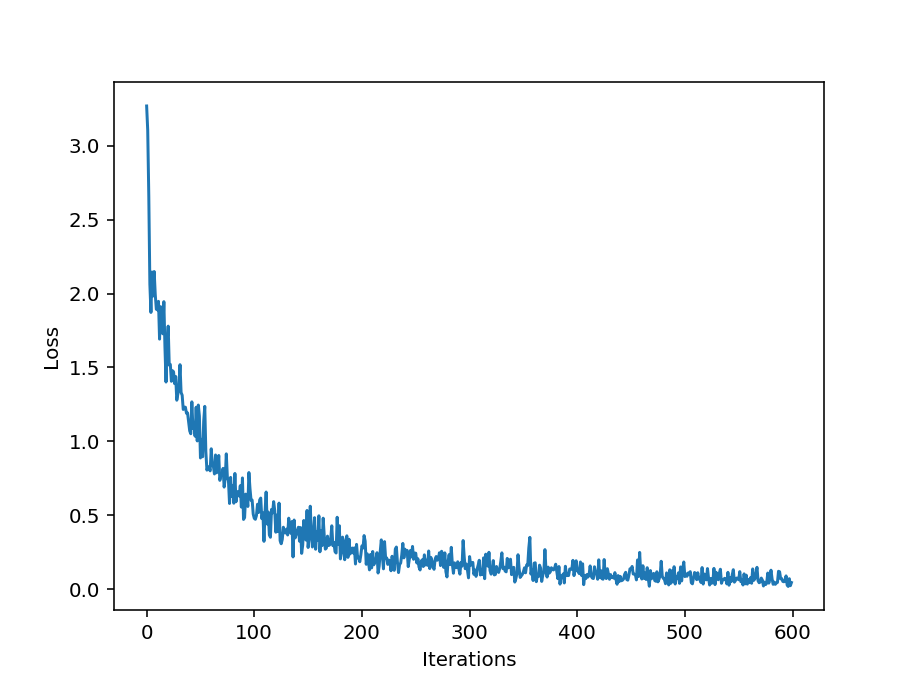

In [49]:
%matplotlib notebook
loss = train_pipeline.get_variable("loss_history")
plt.plot(loss)
plt.xlabel("Iterations"), plt.ylabel("Loss")
plt.show()

График после 170 итераций выходит на плато, что позволяет говорить о сходимости процесса обучения.

## Оценка модели

Качество модели оценивается по метрикам `precision`, `recall` и `f1-score` по случайной выборке из 1000 кропов с центрами в размеченных точках .

Описание тестового пайплайна:

In [50]:
test_pipeline = (imset.p
                 .load(fmt="segy")
                 .load(fmt="pts")
                 .init_variable('predictions', init_on_each_run=list())
                 .init_variable('targets', init_on_each_run=list())
                 .import_model('cnet', train_pipeline)
                 .sample_crops(slice_axis, annotated_slice, crop_half_size, crop_batch_size)
                 .update_variable('targets', B('labels'), mode='e')
                 .predict_model('cnet', fetches='proba',
                                feed_dict={'images': B('images')},
                                save_to=V('predictions'), mode="e"))

Запуск тестового пайплайна

In [51]:
test_pipeline = test_pipeline.run(1, n_epochs=1, bar=False)

Расчет метрик

In [52]:
true_labels = test_pipeline.get_variable('targets')
pred_labels = np.argmax(test_pipeline.get_variable('predictions'), axis=-1)
label_names = [os.path.split(p)[1][6:-9] for p in glob.glob("/home/egor/Desktop/Dutch F3 seismic data/m*.pts")]

print(classification_report(true_labels, pred_labels, target_names=label_names))

                     precision    recall  f1-score   support

         steep_dips       0.99      0.97      0.98        70
     high_amplitude       0.96      1.00      0.98       101
               else       0.94      0.98      0.96       143
            grizzly       1.00      0.94      0.97       143
high_amp_continuous       0.99      0.96      0.97        99
               salt       0.90      1.00      0.95        44
      low_amplitude       0.99      1.00      1.00       134
       low_amp_dips       1.00      0.97      0.99       140
      low_coherency       1.00      1.00      1.00       126

        avg / total       0.98      0.98      0.98      1000



Для визуальной оценки качества разметки фаций проводится доразметка частично размеченного среза с высоким разрешением (каждый пиксель) и разметка всего куба с более низким разрешением (по узлам сетки с размеров 10 пикселей).

Описание процедуры доразметка частично размеченного среза:

In [59]:
iter_config = {"slice_axis": 0,
               "slice_indices": np.array([annotated_slice]),
               "batch_size": 1000,
               "strides": 1,
              }

predict_pipeline = (imset.p
                    .load(fmt="segy")
                    .init_variable("counters", init_on_each_run=None)
                    .import_model('cnet', train_pipeline)
                    .init_variable('predictions', init_on_each_run=list())
                    .update_variable("counters",
                                     F(update_counters, V("counters"), iter_config))
                    .next_crops(iter_config["slice_axis"],
                                F(get_slice_index, V("counters"), iter_config),
                                iter_config["batch_size"], crop_half_size,
                                iter_config["strides"],
                                F(get_start_index, V("counters"), iter_config))
                    .predict_model('cnet', fetches='proba',
                                   feed_dict={'images': B('images')},
                                   save_to=V('predictions'), mode="a"))

Запуск разметки среза

In [60]:
predict_pipeline = predict_pipeline.run(1, n_epochs=None, bar=False)

Размеченные фации

<IPython.core.display.Javascript object>


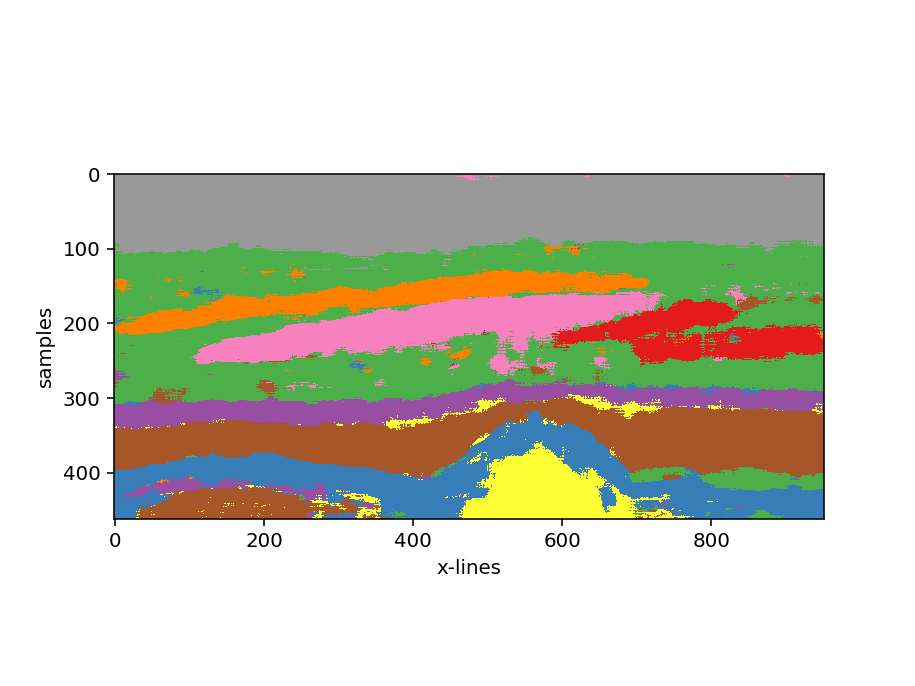

In [61]:
%matplotlib notebook

predicts = np.vstack(predict_pipeline.get_variable("predictions"))
predicts = predicts.reshape(batch.traces[0].shape[1:] + (-1,))
predicts = np.squeeze(np.argmax(predicts, axis=-1))

plt.imshow(predicts.T, cmap="Set1")
plt.xlabel(axes_names[0]), plt.ylabel(axes_names[1])
plt.show()

Описание процедуры разметки куба. Разметка делается в уменьшенном разрешении по узлам сетки с размером 10 пикселей.

In [62]:
iter_config = {"slice_axis": 0,
               "slice_indices": np.arange(0, batch.traces[0].shape[0], 10),
               "batch_size": 1000,
               "strides": 10,
              }

predict_pipeline = (imset.p
                    .load(fmt="segy")
                    .init_variable("counters", init_on_each_run=None)
                    .import_model('cnet', train_pipeline)
                    .init_variable('predictions', init_on_each_run=list())
                    .update_variable("counters",
                                     F(update_counters, V("counters"), iter_config))
                    .next_crops(iter_config["slice_axis"],
                                F(get_slice_index, V("counters"), iter_config),
                                iter_config["batch_size"], crop_half_size,
                                iter_config["strides"],
                                F(get_start_index, V("counters"), iter_config))
                    .predict_model('cnet', fetches='proba',
                                   feed_dict={'images': B('images')},
                                   save_to=V('predictions'), mode="a"))

Запуск разметки куба

In [63]:
predict_pipeline = predict_pipeline.run(1, n_epochs=None, bar=False)

In [64]:
img_shape = np.ceil(np.delete(batch.traces[0].shape, iter_config["slice_axis"])
                    / iter_config["strides"]).astype(int)

cube_predicts = np.vstack(predict_pipeline.get_variable("predictions"))
cube_predicts = cube_predicts.reshape((len(iter_config["slice_indices"]),)
                                      + tuple(img_shape) + (-1,))
cube_predicts = np.argmax(cube_predicts, axis=-1)

Просмотро размеченного куба вдоль произвольной оси (параметр `axes`)

<IPython.core.display.Javascript object>


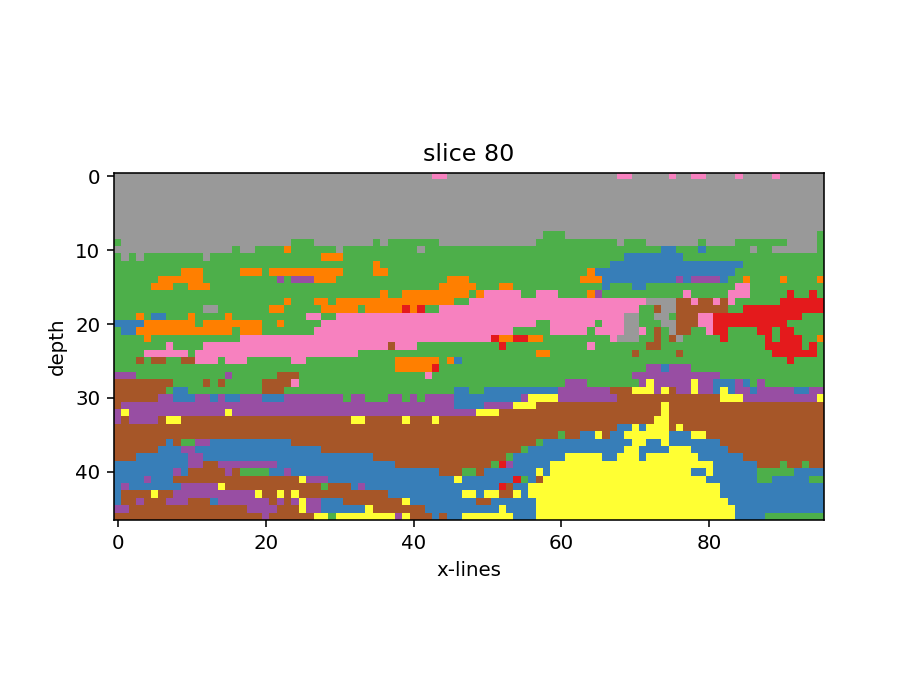

In [65]:
%matplotlib notebook

scroll_step = 1
slice_axis = 0
axes_names = np.delete(["i-lines", "x-lines", "depth"], slice_axis)

fig, ax = plt.subplots(1, 1)
ax.set_xlabel(axes_names[0]), ax.set_ylabel(axes_names[1])
tracker = IndexTracker(ax, np.transpose(cube_predicts, (2, 1, 0)),
                       slice_names=iter_config["slice_indices"], cmap="Set1")
fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

## Критика модели

Как видно из картинок выше, в однородных структурах встречаются неожиданные вкропления другий фаций. По-видимому, это происходит из-за того, что модель размечает точки независимо и недостаточного учитывает окружающую среду.

## Краткое резюме

Модель, обученная на одном частично размеченном срезе куба, позволяет дополнять разметку этого среза и распространять ее на весь куб. При этом сохраняется глобальная непрерывность стурктур. Локальные нехарактерные  включения фаций можно связать с недостаточным учетом окружающей среды при разметке данного участка.

Показатели работы модели (на примере ноутбука с процессором i5) 
* время обучения ~ 1 мин
* скорость разметки ~ 40К точек/мин.

## Предложения по улучшению и развитию модели

Для повышения устойчивости разметки имеет смысл попробовать использовать 3D свертки и включать больше информации об окружающих точках.